In [1]:
from __future__ import print_function
import argparse
import os
from math import log10

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch.backends.cudnn as cudnn

from networks import define_G, define_D, GANLoss, get_scheduler, update_learning_rate
from data import get_dataset,get_training_set,get_test_set
from data import *
from networks import *
import matplotlib.pyplot as plt
import os

In [2]:
# Training settings
parser = argparse.ArgumentParser(description='pix2pix-pytorch-implementation')
#parser.add_argument('--dataset', required=True, help='facades')
parser.add_argument('--batch_size', type=int, default=1, help='training batch size')
parser.add_argument('--test_batch_size', type=int, default=1, help='testing batch size')
parser.add_argument('--direction', type=str, default='b2a', help='a2b or b2a')
parser.add_argument('--input_nc', type=int, default=1, help='input image channels')
parser.add_argument('--output_nc', type=int, default=1, help='output image channels')
parser.add_argument('--ngf', type=int, default=32, help='generator filters in first conv layer')
parser.add_argument('--ndf', type=int, default=32, help='discriminator filters in first conv layer')
parser.add_argument('--epoch_count', type=int, default=1, help='the starting epoch count')
parser.add_argument('--niter', type=int, default=100, help='# of iter at starting learning rate')
parser.add_argument('--niter_decay', type=int, default=100, help='# of iter to linearly decay learning rate to zero')
parser.add_argument('--lr', type=float, default=0.0002, help='initial learning rate for adam')
parser.add_argument('--lr_policy', type=str, default='lambda', help='learning rate policy: lambda|step|plateau|cosine')
parser.add_argument('--lr_decay_iters', type=int, default=50, help='multiply by a gamma every lr_decay_iters iterations')
parser.add_argument('--beta1', type=float, default=0.5, help='beta1 for adam. default=0.5')
parser.add_argument('--cuda', action='store_true', help='use cuda?')
parser.add_argument('--threads', type=int, default=4, help='number of threads for data loader to use')
parser.add_argument('--seed', type=int, default=123, help='random seed to use. Default=123')
parser.add_argument('--lamb', type=int, default=10, help='weight on L1 term in objective')
opt = parser.parse_args()

usage: ipykernel_launcher.py [-h] [--batch_size BATCH_SIZE]
                             [--test_batch_size TEST_BATCH_SIZE]
                             [--direction DIRECTION] [--input_nc INPUT_NC]
                             [--output_nc OUTPUT_NC] [--ngf NGF] [--ndf NDF]
                             [--epoch_count EPOCH_COUNT] [--niter NITER]
                             [--niter_decay NITER_DECAY] [--lr LR]
                             [--lr_policy LR_POLICY]
                             [--lr_decay_iters LR_DECAY_ITERS] [--beta1 BETA1]
                             [--cuda] [--threads THREADS] [--seed SEED]
                             [--lamb LAMB]
ipykernel_launcher.py: error: unrecognized arguments: -f /users/mliu/.local/share/jupyter/runtime/kernel-04020947-c650-44cf-a0ba-75d2283d7d1d.json


SystemExit: 2

/jhpce/shared/jhpce/core/python/3.9.10/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3406: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [3]:
root_path = "dataset/"
xtrain,ytrain,xtest,ytest = get_dataset()
train_set = get_training_set(xtrain,ytrain)
test_set = get_test_set(xtest,ytest)

training_data_loader = DataLoader(dataset=train_set, num_workers=4, batch_size=1, shuffle=True)
testing_data_loader = DataLoader(dataset=test_set, num_workers=4, batch_size=1, shuffle=False)

training data found, so just load it
loaded xtrain_master_noaug_unet2d_320x320x120(60)(60)_[320x320]_psm9.npy shape:  (600, 320, 320, 1)
loaded ytrain_master_noaug_unet2d_320x320x120(60)(60)_[320x320]_psm9.npy shape:  (600, 320, 320, 1)
use 80% for training, 20% for testing


/users/mliu/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [13]:
for iteration, batch in enumerate(training_data_loader, 1):
    print("iteration", iteration)
    # forward
    real_a,real_b = batch[0],batch[1]
    print(batch[0].shape)
    print(batch[1].shape)
    break

iteration 1
torch.Size([1, 1, 320, 320])
torch.Size([1, 1, 320, 320])


In [5]:
device = torch.device("cuda:0" if False else "cpu")
print("device is: ",device)
net_g = define_G(1, 1, 32, 'batch', False, 'normal', 0.02, gpu_id=device)
net_d = define_D(1+1, 32, 'basic', gpu_id=device)

device is:  cpu
initialize network with normal
initialize network with normal


In [6]:
fake_b = net_g(real_a)

In [7]:
fake_b.shape

torch.Size([1, 1, 320, 320])

In [8]:
class Inconv(nn.Module):
    def __init__(self, in_ch, out_ch, norm_layer, use_bias):
        super(Inconv, self).__init__()
        self.inconv = nn.Sequential(
            #nn.ReflectionPad2d(3),
            nn.Conv2d(in_ch, out_ch, kernel_size=7, padding='same',
                      bias=use_bias),
            norm_layer(out_ch),
            nn.ReLU(True)
        )

    def forward(self, x):
        x = self.inconv(x)
        return x

In [9]:
norm_layer=nn.BatchNorm2d
padding_type='reflect'
n_blocks=9
ngf = 32
if type(norm_layer) == functools.partial:
    use_bias = norm_layer.func == nn.InstanceNorm2d
else:
    use_bias = norm_layer == nn.InstanceNorm2d
inc = Inconv(1, 32, norm_layer, use_bias)
down1 = Down(ngf, ngf * 2, norm_layer, use_bias)
down2 = Down(ngf * 2, ngf * 4, norm_layer, use_bias)

model = []
for i in range(n_blocks):
    model += [ResBlock(ngf * 4, padding_type=padding_type, norm_layer=norm_layer, use_dropout=False, use_bias=use_bias)]
resblocks = nn.Sequential(*model)

up1 = Up(ngf * 4, ngf * 2, norm_layer, use_bias)
up2 = Up(ngf * 2, ngf, norm_layer, use_bias)

outc = Outconv(ngf, 1)

In [10]:
out = {}
out['in'] = inc(real_a)
out['d1'] = down1(out['in'])
out['d2'] = down2(out['d1'])
out['bottle'] = resblocks(out['d2'])
out['u1'] = up1(out['bottle'])
out['u2'] = up2(out['u1'])

In [11]:
for k, v in out.items():
    print(k,v.shape)

in torch.Size([1, 32, 320, 320])
d1 torch.Size([1, 64, 160, 160])
d2 torch.Size([1, 128, 80, 80])
bottle torch.Size([1, 128, 80, 80])
u1 torch.Size([1, 64, 160, 160])
u2 torch.Size([1, 32, 320, 320])


In [14]:
real_ab = torch.cat((real_a, real_b), 1)
pred_real = net_d.forward(real_ab)

In [18]:
print(pred_real.shape)
print(pred_real)

torch.Size([1, 1, 38, 38])
tensor([[[[-0.4014, -0.6953, -0.2937,  ..., -0.7815, -0.8776, -0.1942],
          [-0.5678, -0.2522, -0.3157,  ...,  0.8800, -0.6010, -0.7858],
          [-0.1545,  0.5837, -0.3837,  ..., -0.7986, -0.7749,  0.4032],
          ...,
          [ 0.3081,  0.0921, -0.0438,  ..., -0.5488, -0.7284,  0.5330],
          [ 0.7234,  0.2641,  1.2546,  ..., -0.0343, -0.5093,  0.6580],
          [ 0.2297, -0.0526,  0.3564,  ...,  0.5945,  0.1578,  0.3585]]]],
       grad_fn=<ConvolutionBackward0>)


In [17]:
real_ab.shape

torch.Size([1, 2, 320, 320])

In [2]:
from __future__ import print_function
import argparse
import os

import torch
import torchvision.transforms as transforms

from utils import is_image_file, load_img, save_img

In [18]:
device = torch.device("cuda:0" if False else "cpu")
model_path = "checkpoint/netG_model_epoch_{}.pth".format("106")

net_g = torch.load(model_path,map_location=torch.device('cpu')).to("cpu")

In [4]:
out_dir = "checkpoint/result/"

if not os.path.exists(out_dir):
    os.makedirs(out_dir)

In [5]:
script_path =os.getcwd()
image_dir = os.path.join(script_path, "../../ARIC/pd_wip/pd_nifti_final/pd_test")

image_filenames = [x for x in os.listdir(image_dir) if x.endswith('.gz')]
print(image_filenames)

['F142809-20180612_143304_PD_SPACE_0.5_20180612094709_14.nii.gz', 'J163559-20181016_195250_PD_SPACE_0.5_20181016091512_9.nii.gz', 'J295294-20180814_125257_PD_SPACE_0.5_20180814081237_14.nii.gz', 'J174111-20180814_100254_PD_SPACE_0.5_20180814102653_16.nii.gz', 'F257967-20171127_121728_pd_spc_cor_p2_iso_.5mm_1800ms_Linear_20171127111451_14.nii.gz', 'F184439-20171128_114803_pd_spc_cor_p2_iso_.5mm_1800ms_Linear_20171128104752_14.nii.gz', 'M206322-20190110_105738_PD_SPACE_0.5_20190110093725_9.nii.gz', 'J147132-20180605_105235_PD_SPACE_0.5_20180605090213_15.nii.gz', 'F108323-20181108_131336_PD_SPACE_0.5_20181108114933_8.nii.gz', 'J242158-20190326_122615_PD_SPACE_0.5_20190326101928_18.nii.gz', 'F158205-20171127_133328_pd_spc_cor_p2_iso_.5mm_1800ms_Linear_20171127121325_14.nii.gz', 'M293693-20190618_113101_PD_SPACE_0.5_20190618100440_9.nii.gz', 'M304434-20180802_111238_PD_SPACE_0.5_20180802094528_13.nii.gz', 'F227926-20180208_135305_PD_SPACE_0.5_20180208121032_15.nii.gz', 'M173590-20181025_101

In [19]:
image_name = "F158205-20171127_133328_pd_spc_cor_p2_iso_.5mm_1800ms_Linear_20171127121325_14.nii.gz"#image_filenames[0]
volume1 = load_tiff_volume_and_scale_si(image_dir, image_name)
volume1 = volume1.transpose(2,0,1)
print(volume1.shape)
img = np.expand_dims(volume1,-1)
print(img.shape)
img = img.transpose(0,3,1,2)
print(img.shape)
input = torch.from_numpy(img)
out = net_g(input)

volume's shape (320, 320, 128)
max signal value is 246.0
min signal value is 0.0
(128, 320, 320)
(128, 320, 320, 1)
(128, 1, 320, 320)


(320, 320, 128)


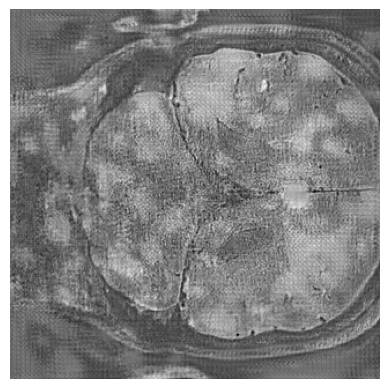

In [20]:
out_img = out.detach().squeeze(1).cpu()
out_img = out_img.numpy().transpose(1,2,0)

plt.imshow(out_img[:, :, 1], cmap='gray')
plt.axis('off');
print(out_img.shape)
#FileSave(out_img,out_dir+image_name)

In [ ]:
for image_name in image_filenames:
    #img = load_img(image_dir + image_name)
    #img = transform(img)
    #input = img.unsqueeze(0).to(device)
    volume1 = load_tiff_volume_and_scale_si(image_dir + image_name, icode)
    input = volume1.transpose(2,0,1)
    out = net_g(input)
    out_img = out.detach().squeeze(0).cpu()

    if not os.path.exists(os.path.join("result", opt.dataset)):
        os.makedirs(os.path.join("result", opt.dataset))
    save_img(out_img, "result/{}/{}".format(opt.dataset, image_name))